In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
#from mpl_toolkits.basemap import Basemap
import pandas as pd
import numpy as np

from collections import Counter

from sklearn.cluster import KMeans, DBSCAN

from sklearn.manifold import TSNE
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Business Understanding (10 points total).
Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs? 

We selected this dataset because we wanted to analyze the sales stats of an online retailer.

# Data Understanding (20 points total)
Describe the meaning and type of data (scale, values, etc.) for each
attribute in the data file. Verify data quality: Are there missing values? Duplicate data?
Outliers? Are those mistakes? How do you deal with these problems? 

### Data Exploration:
There are 541,909 records in our online marketing data research. This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

Following are the factor names and descriptions:

* InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

* StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

* Description: Product (item) name. Nominal. 

* Quantity: The quantities of each product (item) per transaction. Numeric.	

* InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated. 

* UnitPrice: Unit price. Numeric, Product price per unit in sterling. 

* CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 

* Country: Country name. Nominal, the name of the country where each customer resides. 


In [2]:
marketing_data = pd.read_excel('./Data/Online Retail.xlsx')

In [3]:
marketing_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Data types:
marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


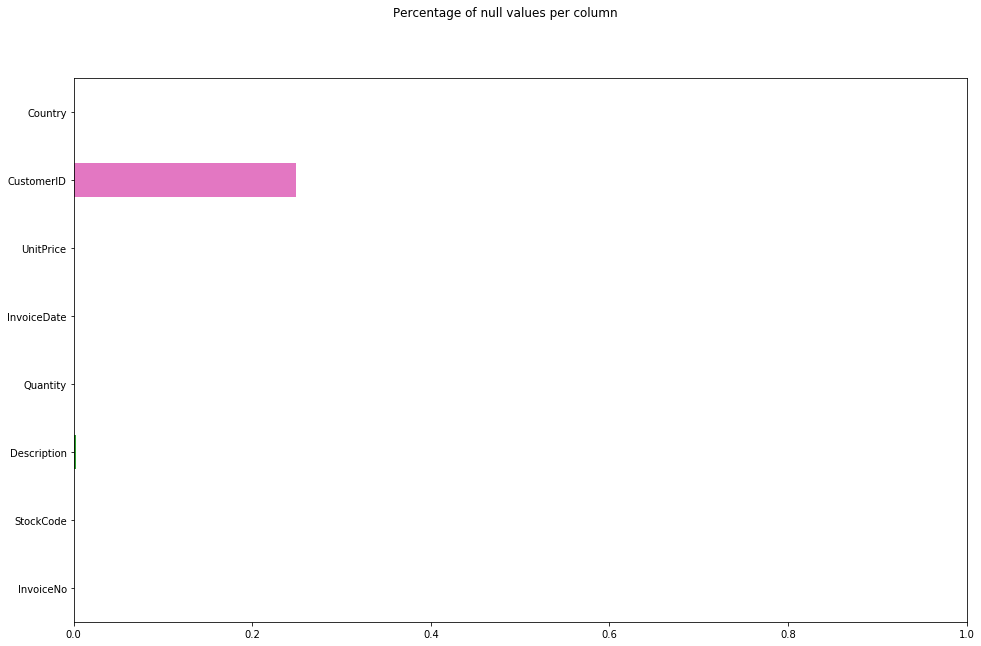

In [5]:
plt.figure(figsize=(16,10))
plt.xlim(0,1)
plt.suptitle('Percentage of null values per column')
marketing_data.isnull().mean().plot.barh();
plt.show()

In [6]:
# Find and remove the duplicate records:
print('Duplicated records: {}'.format(marketing_data.duplicated().sum()))
marketing_data.drop_duplicates(inplace = True)

Duplicated records: 5268


In [7]:
marketing_data.shape

(536641, 8)

In [8]:
# Find the number of missing values in each column:
print(marketing_data.isnull().sum(axis=0))

na_cols = marketing_data.loc[:,marketing_data.isnull().mean()>.0].columns

for col in na_cols:
    print(col, ' column is ',round(marketing_data[col].isnull().mean(),5)*100,'% null')

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64
Description  column is  0.271 % null
CustomerID  column is  25.163000000000004 % null


By looking at the number of missing values in each attribute, there are 135,080 records, almost 25%,  that do not have a Customer ID.  We will assign an individual customer ID for missings in each country. (these customers ID start with 99999 to track them and keep the integer type).

In [9]:
#Change the rows with missing  data in CustomerID column:
marketing_data.dropna(subset=['Description'], inplace=True)
# marketing_data['CustomerID'].fillna(99999, inplace=True)

def marketing_data(CustomerID, Country):
    if ([CustomerID] is None and Country=='Bahrain'):
        CustomerID= 999991
    elif [CustomerID] is None and Country=='EIRE':
        CustomerID= 999992
    elif [CustomerID] is None and Country=='France':
        CustomerID= 999993
    elif[CustomerID] is none and Country=='Hong Kong':
        CustomerID= 999994
    elif[CustomerID] is none and Country=='Israel':
        CustomerID= 999995
    elif[CustomerID] is none and Country=='Portugal':
        CustomerID= 999996
    elif[CustomerID] is none and Country=='Switzerland':
        CustomerID= 999997
    elif[CustomerID] is none and Country=='United Kingdom':
        CustomerID= 999998
    elif[CustomerID] is none and Country=='Unspecified':
        CustomerID= 999990


    return CustomerID

In [66]:
# Now we have a dataset with no missings
marketing_data.isnull().sum(axis=0)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [67]:
# Dimention of the dataset after removing missings:
marketing_data.shape

(540455, 8)

We are replacing all descriptions that don't have any letters or are not strings.
Crate a new feature in the data set called TotalPrice. This feature will provide some insight into
how much money was spent on a specific item per transaction.

In [68]:
for ind,el in enumerate(marketing_data['Description']):
    if type(el) != str:
        marketing_data.loc['Description',ind]='Unknown'
   elif re.match('.*[a-zA-Z]+.*',el) is not None:
       pass
   else:
       marketing_data.loc[ind,'Description']='Unknown'
        
# Create the TotalPrice feature
marketing_data['TotalPrice'] = marketing_data['Quantity']*marketing_data['UnitPrice']

In [85]:
per_country = marketing_data.groupby(['Country']).nunique()
per_country= per_country.drop('Country',axis=1)
per_country.reset_index(level=0, inplace=True)
per_country[['Country','InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID']]


,Country,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID
0,Australia,69,600,609,67,66,77,9
1,Austria,19,307,307,23,19,44,11
2,Bahrain,4,16,16,10,4,9,3
3,Belgium,119,778,785,38,119,66,25
4,Brazil,1,32,32,7,1,16,1
5,Canada,6,147,147,19,6,30,4
6,Channel Islands,33,430,436,25,33,55,9
7,Cyprus,20,498,498,29,20,56,8
8,Czech Republic,5,25,25,12,5,17,1
9,Denmark,21,251,252,35,21,44,9


The chart below shows the number of unique customer ID's per country

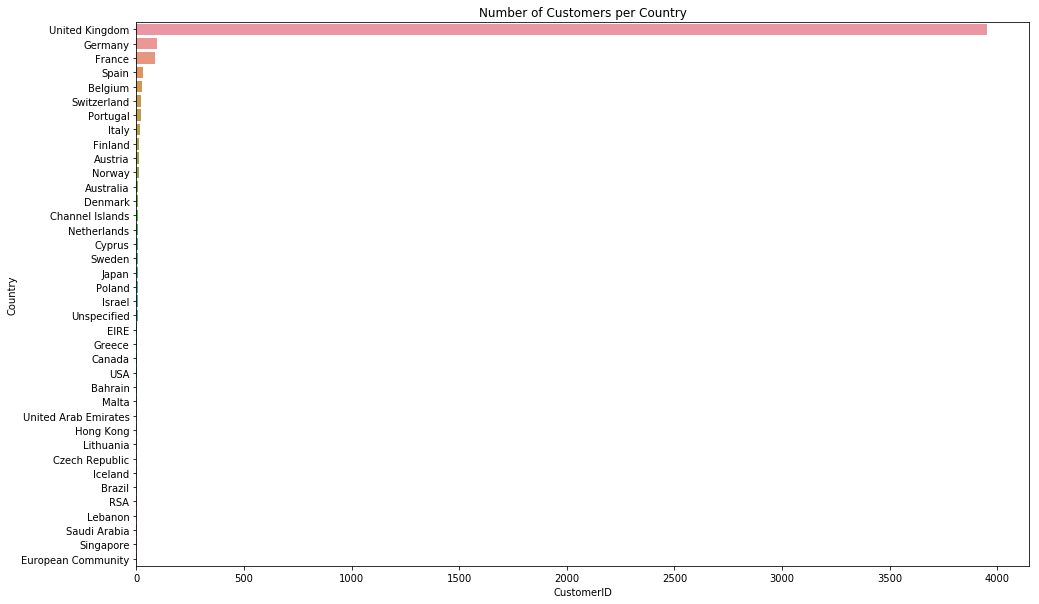

In [130]:
per_country.sort_values(by=['CustomerID'],ascending=False,inplace=True)
num_cust = per_country['CustomerID']
country = per_country['Country']
plt.figure(figsize=(16,10))
#plt.barh(country, num_cust,)
#plt.xticks(y_pos, country )
#ax = sns.barplot(x=num_cust,y=country,orient='h')
#ax.set(xlabel ='Number of Customer', ylabel='Country')
plt.title('Number of Customers per Country')
plt.xlabel('Number of Customers')
#ax.fig.set_size_inches(15,15)
sns.barplot(x=num_cust,y=country,orient='h')
plt.show()

In fact over 90% of customers are from the United Kingdom

90.02% of customers are in the United Kingdom


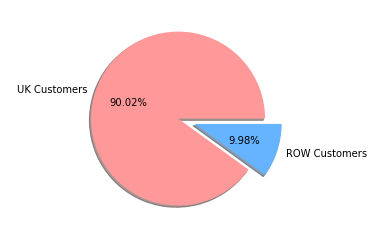

In [101]:
cust_UK_row = per_country.loc[per_country['Country'] =='United Kingdom']
cust_UK = cust_UK_row['CustomerID'].sum()
cust_ROW_row = per_country.loc[per_country['Country']!='United Kingdom']
cust_ROW = cust_ROW_row['CustomerID'].sum()

print ('{0:.2%} of customers are in the United Kingdom'.format((cust_UK/(cust_UK+cust_ROW))))
labels = 'UK Customers','ROW Customers'
cust_count = [cust_UK, cust_ROW]
colors = ['#ff9999','#66b3ff']
explode = [0,0.2]
plt.axis('equal')   
plt.pie(cust_count, labels=labels, explode=explode, colors=colors, autopct='%1.2f%%', shadow=True, startangle=0)
plt.show()

In [87]:
count_by_country = marketing_data.groupby(['Country']).count()
count_by_country['Avg_UnitPrice'] = marketing_data.groupby(['Country'])['UnitPrice'].mean()
count_by_country['Avg_Quantity'] = marketing_data.groupby(['Country'])['Quantity'].mean()
count_by_country['Avg_TotalPrice'] = marketing_data.groupby(['Country'])['TotalPrice'].mean()
count_by_country.reset_index(level=0, inplace=True)
count_by_country.sort_values(by=['CustomerID'],ascending=False,inplace=True)


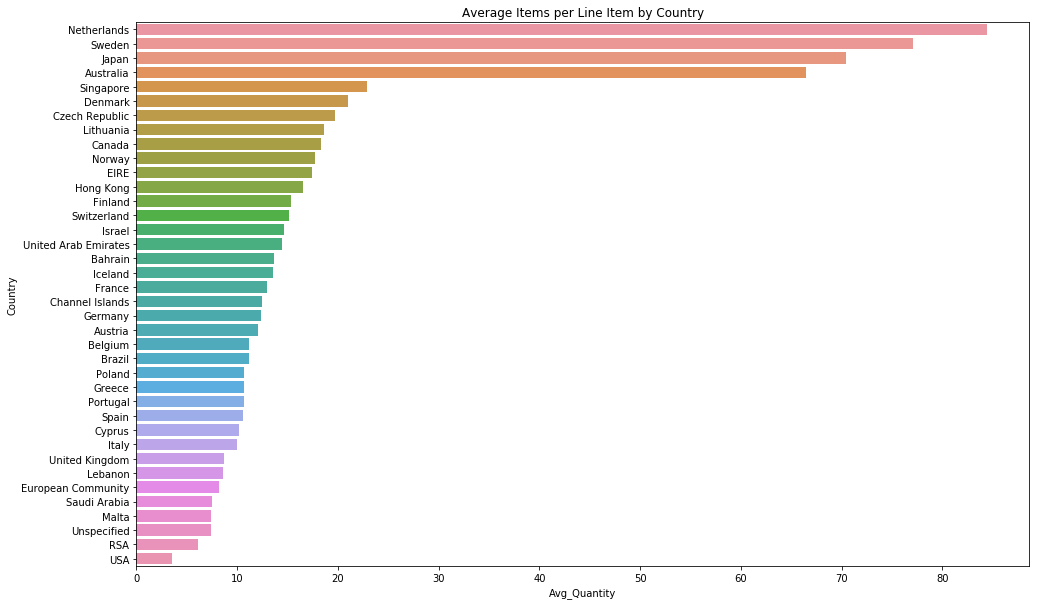

,Avg_Quantity,Country
24,84.406580,Netherlands
32,77.136364,Sweden
20,70.441341,Japan
0,66.444003,Australia
30,22.855895,Singapore
9,21.048843,Denmark
8,19.733333,Czech Republic
22,18.628571,Lithuania
5,18.298013,Canada
25,17.722836,Norway


In [127]:
count_by_country.sort_values(by=['Avg_Quantity'],ascending=False,inplace=True)
avg_quantity = count_by_country['Avg_Quantity']

country = count_by_country['Country']
plt.figure(figsize=(16,10))
plt.title('Average Items per Line Item by Country')
plt.xlabel('Number of Customers')
#ax.fig.set_size_inches(15,15)
sns.barplot(x=avg_quantity,y=country,orient='h')
plt.show()
display(count_by_country[['Avg_Quantity', 'Country']])

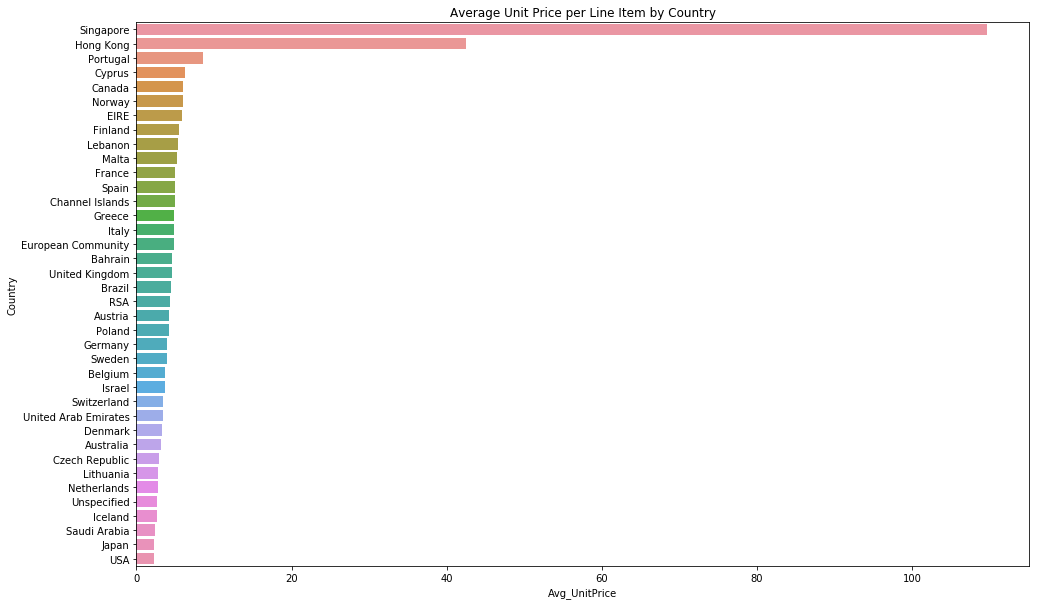

,Avg_UnitPrice,Country
30,109.645808,Singapore
16,42.505208,Hong Kong
27,8.582976,Portugal
7,6.302363,Cyprus
5,6.030331,Canada
25,6.012026,Norway
10,5.911077,EIRE
12,5.448705,Finland
21,5.387556,Lebanon
23,5.244173,Malta


In [129]:
count_by_country.sort_values(by=['Avg_UnitPrice'],ascending=False,inplace=True)
avg_price = count_by_country['Avg_UnitPrice']

country = count_by_country['Country']
plt.figure(figsize=(16,10))
plt.title('Average Unit Price per Line Item by Country')
plt.xlabel('Number of Customers')
total = float(len(count_by_country))
#ax.fig.set_size_inches(16,10)
sns.barplot(x=avg_price,y=country,orient='h')
plt.show()
display(count_by_country[['Avg_UnitPrice', 'Country']])

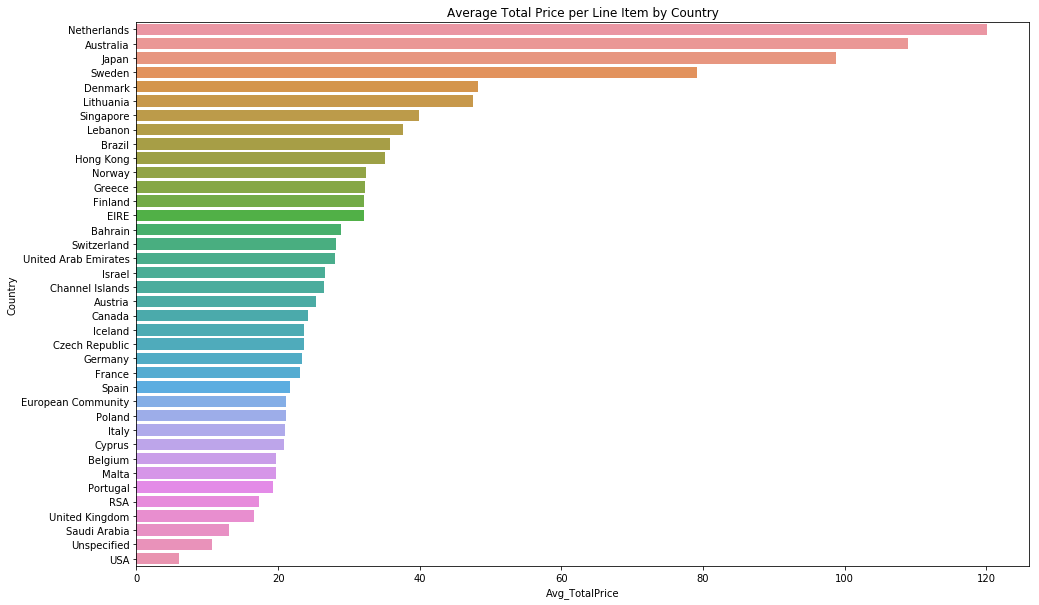

,Avg_TotalPrice,Country
24,120.059696,Netherlands
0,108.877895,Australia
20,98.716816,Japan
32,79.211926,Sweden
9,48.247147,Denmark
22,47.458857,Lithuania
30,39.827031,Singapore
21,37.641778,Lebanon
4,35.737500,Brazil
16,35.128611,Hong Kong


In [128]:
count_by_country.sort_values(by=['Avg_TotalPrice'],ascending=False,inplace=True)
avg_sale = count_by_country['Avg_TotalPrice']

country = count_by_country['Country']
plt.figure(figsize=(16,10))
plt.title('Average Total Price per Line Item by Country')
plt.xlabel('Number of Customers')
#ax.fig.set_size_inches(15,15)
sns.barplot(x=avg_sale,y=country,orient='h')
plt.show()
display(count_by_country[['Avg_TotalPrice', 'Country']])

Here we examine each transaction's Total Price  by country, looking for outliers.  Since Total Price is a combination of Quantity and Unit Price, we will be able to check both of these features with this chart.

,Quantity,UnitPrice,CustomerID,TotalPrice
count,540455.000000,540455.000000,540455.000000,540455.000000
mean,9.603129,4.623519,36232.326912,18.036188
std,218.007598,96.889628,36575.711219,379.318894
min,-80995.000000,-11062.060000,12346.000000,-168469.600000
25%,1.000000,1.250000,14364.000000,3.480000
50%,3.000000,2.080000,16241.000000,9.840000
75%,10.000000,4.130000,18257.000000,17.400000
max,80995.000000,38970.000000,99999.000000,168469.600000


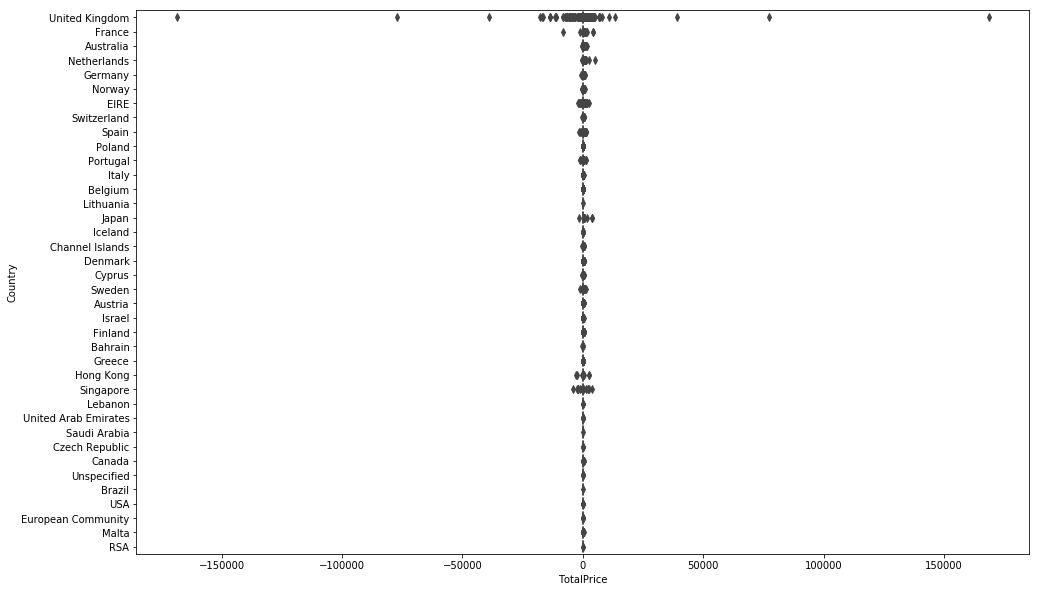

In [42]:
marketing_data['TotalPrice'] = marketing_data['UnitPrice'] *  marketing_data['Quantity']
plt.figure(figsize=(16,10))
sns.boxplot(x='TotalPrice', y='Country', data=marketing_data, orient='h')
display (marketing_data.describe())

The graph above is not very granular, however we can see some outliers from the United Kingdom.  The outlier seem to be symetric so we need to examine these.  The outliers appear to all be above $3500 and below -$3500.  Below we look for the transactions that meet this criteria.

In [45]:
min_sales = marketing_data.loc[(marketing_data['TotalPrice'] < -35000)]
max_sales = marketing_data.loc[(marketing_data['TotalPrice'] > 35000)]

display(min_sales)
display(max_sales)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.6
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,-38970.0
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,-168469.6


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.6
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.0
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.6


The Invoice numbers for all the high value negative transactions have a 'C' at the beginning.  We can speculate these are cancelled orders.  The Stock codes for two of the three matching transactions also match.  This is further proof these are not mistakes, but actual orders that were cancelled.  We will retain them in the data set.

In [51]:
#
# Create some lists for visualizations
#
count_by_country = marketing_data.groupby(['Country']).count()
count_by_country['Avg_UnitPrice'] = marketing_data.groupby(['Country'])['UnitPrice'].mean()
count_by_country['Avg_Quantity'] = marketing_data.groupby(['Country'])['Quantity'].mean()
count_by_country['Avg_TotalPrice'] = marketing_data.groupby(['Country'])['TotalPrice'].mean()
count_by_country.reset_index(level=0, inplace=True)
count_by_country.sort_values(by=['CustomerID'],ascending=False,inplace=True)
count_by_country.reset_index(drop=True,inplace=True)

country = count_by_country['Country']
num_cust = count_by_country['CustomerID'].nunique()

avg_sale = count_by_country['Avg_TotalPrice']

In [ ]:
The charts above shows the United Kingdom has far more transactions

### Grouping values by transactions by Invoice Number

Here we are creating a column which gives a transaction total price (quantity * unite price). Next we are grouping all transactions by their invoice number.

In [16]:
marketing_data_grouping = marketing_data.groupby(['InvoiceNo','InvoiceDate','Country','CustomerID'], as_index=False)['UnitPrice','Description','Quantity','TotalPrice'].agg(lambda x: list(x))


##This is to remove any decriptions that may not be strings   
for ind,el in enumerate(marketing_data_grouping['Description']):
    if type(el[0]) != str:
        marketing_data_grouping.drop(ind,inplace=True)

#This will sum the total price for each invoice
marketing_data_grouping['TotalPrice'] = marketing_data_grouping['TotalPrice'].apply(sum)

### Classify Transaction type

In [25]:
marketing_data_grouping['Transaction']=''

for index,row in marketing_data_grouping.iterrows():
     if str(row['InvoiceNo']).startswith("C"):
         marketing_data_grouping.loc[index,'Transaction'] = 'Cancel'
     elif str(row['InvoiceNo']).startswith("A"):
         marketing_data_grouping.loc[index,'Transaction'] = 'Adjust'
     else:
         marketing_data_grouping.loc[index,'Transaction'] = 'Purchase'


In [26]:
marketing_data_grouping.sample(10)

,InvoiceNo,InvoiceDate,Country,CustomerID,UnitPrice,Description,Quantity,TotalPrice,Transaction
21907,C550172,2011-04-14 16:54:00,United Kingdom,17440.0,[0.39],[GOLD SCROLL GLASS T-LIGHT HOLDER],[-3.0],-1.17,Cancel
12807,565141,2011-09-01 13:40:00,United Kingdom,17841.0,"[8.25, 1.45, 1.65, 1.65, 0.42, 0.42, 1.95, 3.7...","[DOORMAT FANCY FONT HOME SWEET HOME, BLUE STRI...","[1.0, 6.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",354.39,Purchase
8926,556470,2011-06-12 11:41:00,United Kingdom,15291.0,"[1.69, 3.95, 5.95, 7.95, 7.95, 0.65, 3.25, 0.9...","[ASSORTED COLOUR BIRD ORNAMENT, CREAM HEART CA...","[8.0, 4.0, 2.0, 2.0, 2.0, 32.0, 4.0, 24.0, 6.0...",301.42,Purchase
413,537210,2010-12-05 15:15:00,United Kingdom,15953.0,"[2.55, 2.95, 2.55, 1.69, 1.69, 2.1, 4.25, 4.25...","[WHITE HANGING HEART T-LIGHT HOLDER, WOODEN FR...","[32.0, 6.0, 6.0, 8.0, 8.0, 1.0, 3.0, 3.0, 1.0,...",209.84,Purchase
23269,C566185,2011-09-09 13:02:00,United Kingdom,18167.0,"[2.1, 2.55, 4.25]","[PIGGY BANK RETROSPOT , RED RETROSPOT MUG, RED...","[-1.0, -1.0, -2.0]",-13.15,Cancel
13198,566005,2011-09-08 11:56:00,United Kingdom,16426.0,"[0.79, 0.79, 1.65, 1.65, 0.39, 2.1, 2.1, 2.08,...","[WHITE STITCHED WALL CLOCK, PINK STITCHED WALL...","[12.0, 1.0, 2.0, 4.0, 8.0, 4.0, 2.0, 3.0, 1.0,...",161.69,Purchase
9515,557775,2011-06-22 15:06:00,United Kingdom,16966.0,"[0.42, 3.25]","[BAG 125g SWIRLY MARBLES, S/6 WOODEN SKITTLES ...","[48.0, 96.0]",332.16,Purchase
3684,545002,2011-02-25 12:43:00,United Kingdom,13001.0,"[3.95, 4.95, 2.95, 2.1, 1.06]","[SET OF 6 SPICE TINS PANTRY DESIGN, SET OF 3 C...","[4.0, 4.0, 4.0, 10.0, 198.0]",278.28,Purchase
11251,561629,2011-07-28 14:13:00,United Kingdom,12748.0,[0.14],[PAPER POCKET TRAVELING FAN ],[12.0],1.68,Purchase
7220,552851,2011-05-11 15:07:00,France,12731.0,"[1.79, 0.85, 0.42, 2.25, 1.95, 1.65, 2.55, 1.9...","[RABBIT NIGHT LIGHT, MINI FUNKY DESIGN TAPES, ...","[120.0, 100.0, 48.0, 24.0, 16.0, 36.0, 24.0, 1...",1381.30,Purchase


Visualize the any important attributes appropriately. Important: Provide an
interpretation for any charts or graphs.

# Modeling and Evaluation (50 points total)
Different tasks will require different evaluation methods. Be as thorough as possible when analyzing
the data you have chosen and use visualizations of the results to explain the performance and
expected outcomes whenever possible. Guide the reader through your analysis with plenty of
discussion of the results.

### Option A: Cluster Analysis
• Perform cluster analysis using several clustering methods
• How did you determine a suitable number of clusters for each method?
• Use internal and/or external validation measures to describe and compare the
clusterings and the clusters (some visual methods would be good).
• Describe your results. What findings are the most interesting and why? 

In [6]:
classify = KMeans(init = 'k-means++')

### Option B: Association Rule Mining
• Create frequent itemsets and association rules.
• Use tables/visualization to discuss the found results.
• Use several measure for evaluating how interesting different rules are.
• Describe your results. What findings are the most compelling and why? 

### Create lists of different descriptions

In [30]:
#from apyori import apriori
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [37]:
mlb = MultiLabelBinarizer().fit_transform(marketing_data['Description'])
# list_purchase_marketing_data_grouping_descriptions = []
# for el in marketing_data_grouping.loc[marketing_data_grouping['Transaction']=='Purchase','Description']:
#     if len(el)>1:
#         list_purchase_marketing_data_grouping_descriptions.append(el)
    
# print(len(list_purchase_marketing_data_grouping_descriptions))

TypeError: 'int' object is not iterable

In [35]:
purchase_rules = apriori(list_purchase_marketing_data_grouping_descriptions, min_support=0.003,min_confidence=.2,min_lift=0.3,min_length=2 )

purchase_results = list(purchase_rules)

KeyboardInterrupt: 

In [33]:
list_cancel_marketing_data_grouping_descriptions = []
for el in marketing_data_grouping.loc[marketing_data_grouping['Transaction']=='Cancel','Description']:
    if len(el)>1:
        list_cancel_marketing_data_grouping_descriptions.append(el)
    
print(len(list_cancel_marketing_data_grouping_descriptions))

1705


In [34]:
cancel_rules = apriori(list_cancel_marketing_data_grouping_descriptions, min_support=0.003,min_confidence=.2,min_lift=0.3,min_length=2 )

cancel_results = list(cancel_rules)

# Deployment (10 points total)
• Be critical of your performance and tell the reader how you current model might be usable by
other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
• How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it)?
• How would your deploy your model for interested parties?
• What other data should be collected?
• How often would the model need to be updated, etc.? 

# Exceptional Work (10 points total)
• You have free reign to provide additional analyses or combine analyses 